Dealing with scoring. Will convert to scripts later 


- must check that size of y and size of scoring file the same
- 

# This jupyter file has code for all graphs and tables at the member level

In [1]:
import sys
import os

import pandas as pd 
import numpy as np
job = 'bagboost'
from code.data_processing import get_data
y = None
import seaborn as sns
from code.decision_fusion.voting import majority_voting

In [2]:
from code.data_processing import get_all_datasets
all_datasets = get_all_datasets()
datasets = {}
for d in all_datasets:
    datasets[d] = get_data(d)

First some kind of measure of how dominant a single classifier is 

# Functions to deal with dataset

In [3]:
# load a single seed of a task with ypred vs observation 
def load_scoring(fn : str) -> np.array: 
    assert('.csv' in fn)
    x = pd.read_csv(fn).transpose().to_numpy()
    assert(len(x.shape) == 2)
    return x 

In [4]:
# load each scoring dataframe for each seed
def load_all_scoring(path : str, training=True) -> np.array: 
    F = []
    for x in os.listdir(path):
        if (not '.csv' in x):
            continue 
        if training:
            if (not 'training' in x):
                continue
        else:
            if (not 'test' in x):
                continue
        F.append(load_scoring(path+'/'+x))
                
    return np.array(F)

In [5]:
# get accuracy of a single member vector on y
def acc_member(X : np.array) -> np.array: # gets the same X for each m ember 
    assert(len(X.shape) == 1)
    assert(len(y) == len(X))
    
    correct = 0
    for i in range(len(y)):
        if y[i] == X[i]: # fail here 
            correct += 1
    return correct / len(X)

In [6]:
# get accuracy of a single seed
def acc_seed(X : np.array) -> np.array:
    assert(len(X.shape) == 2)
    r = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        r[i] = acc_member(X[i])
    return r

In [7]:
# get accuracy over all seeds
def acc_task(X : np.array) -> list: # list not dict for now 
    assert(len(X.shape) == 3)
    r = []
    for i in range(X.shape[0]):
        r.append(acc_seed(X[i]))
    return r

# Preparing datastrucutre of scoring. dictionary : task -> (scoring : np.array, y : np.array)

In [83]:
from sklearn.model_selection import train_test_split
def get_ytrain(j, t, training=True):
    dns = get_all_datasets()
    with open(f'results_file/{j}/{t}/4082125_{t}_info.txt') as f:
        data = f.read()
    for dn in dns:
        if dn in data:
            X, y = get_data(dn)
            seed = 169 * int(t)
            _, _, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)
            if training:
                return y_train
            else:
                return y_test

# LOAD
max_nmembers = -1
all_scoring = {}
for task in os.listdir(f'results_file/{job}'):
    # Not all done
    if len(os.listdir(f'results_file/{job}/{task}')) <= 1:
        print(f'conintued {task}')
        continue 
    # Otherwise load it 
    scoring_task = load_all_scoring(f'results_file/{job}/{task}/scoring/', training=False) # (# seeds, # members in ensemble, # observatins)
    y = get_ytrain(job, task, training=False)
    all_scoring[task] = (scoring_task, y)

# Model Agreement

In [17]:
def agreement(v1 : np.array, v2 : np.array) -> np.array:
    agreement = []
    for i in range(len(v1)):
        if v1[i] == v2[i]:
            agreement.append(1)
        else:
            agreement.append(0)
    return np.array(agreement)

In [80]:
def pairwise_agreement(X : np.array):
    assert(len(X.shape) == 2)
    assert(X.shape[0] > X.shape[1]) # make sure columns are on the y
    
    # Create large numpy vector with (n_members + 1 + 1, n_datapoints) where thes 1s correspond to ypred and ens_pred
    temp = np.ones((X.shape[0], X.shape[1] + 2))
    ens_pred = majority_voting(X.transpose())
    
    temp[:, :X.shape[1]] = X # up to third room from end is input
    temp[:, X.shape[1]] = ens_pred # second row from end is ens pred 
    temp[:, X.shape[1]+1] = y # final row from end is ens pred 
    
    # Pairwise
    full = []
    by_member = {}
    for t1 in temp.transpose():
        for t2 in temp.transpose():
            full.append(agreement(t1, t2))
    
    return np.array(full)

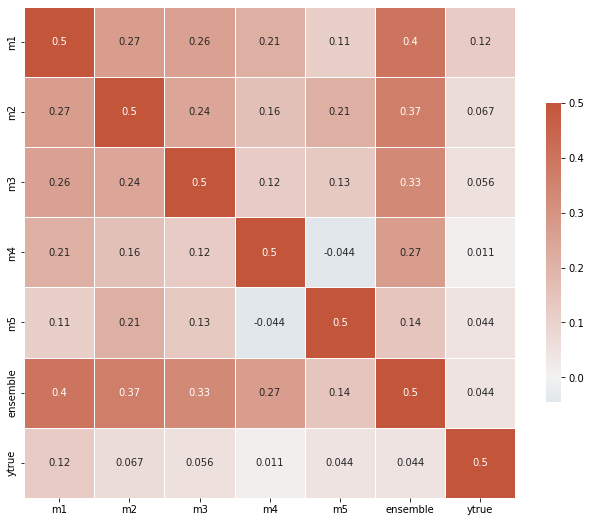

In [124]:
target_task='11'
dsnp, y = all_scoring['11']
dsnp = dsnp[0].transpose() # look at first seed - tranpose bit icky
pw = pairwise_agreement(dsnp)
agre = np.sum(pw, axis=1) / len(y) # sum across data points 
#agre = (agre - np.min(agre)) / (np.max(agre) - np.min(agre)) # normalise
agre = agre.reshape(7,7) - 0.5
mask = np.triu(np.ones_like(agre, dtype=bool))
T= ['m1','m2','m3','m4','m5','ensemble','ytrue']

f, ax = plt.subplots(figsize=(11, 11))
cmap = sns.diverging_palette(230, 20, as_cmap=True, center='light')
sns.heatmap(agre, cmap=cmap, center=0, annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .5},xticklabels=T,yticklabels=T)
plt.savefig(f'prepared_results/agreement_heatmap/heatmap_job{job}_task{task}.png')

# Generating a metric for domination
- m1 different across seed
- num models different models, possibly within model (niche)

In [111]:
# going to just look at distributioin of agreement ratios i think